# Reproducing carbon savings results

This notebook will generate the carbon savings figures/results for the paper using the carbon model artifact. First we will [set up the environment](#Import-packages), then [set up model parameters](#setcalculate-configuration-constantsparameters), then we [reproduce results](#reproducing-table-v-server-configuration-carbon-savings).

Please run through each cell in order to generate the figures. **All generated tables/figures will be saved into the `figures/generated_figures` directory**. You can either compare these directly against those in the paper or against the copies we provide in the `figures/paper_figures_original` directory.

You will know when all the results have been generated once the following four files are created in the `figures/generated_figures` directory (links will only work once notebook is run and figures are generated):
- [`cluster_savings.txt`](../figures/generated_figures/cluster_savings.txt)
- [`dc_savings.txt`](../figures/generated_figures/dc_savings.txt)
- [`Figure_12.png`](../figures/generated_figures/Figure_12.png)
- [`Table_VIII.csv`](../figures/generated_figures/Table_VIII.csv)

The results to reproduce, run times, and output locations are summarized here:

| Result in paper to reproduce | Run time | Output file(s) | 
| --- | --- | --- |
| [Last three columns of Table VIII](../figures/paper_figures_original/Table_VIII.csv) | < 1 minute | [`figures/generated_figures/Table_VIII.csv`](../figures/generated_figures/Table_VIII.csv) |
| Appendix A.C claim: "We re-calculate the average cluster-level savings to find an average of [**14%**](../figures/paper_figures_original/cluster_savings.txt)..." | < 1 minute | [`figures/generated_figures/cluster_savings.txt`](../figures/generated_figures/cluster_savings.txt) (and `carbon_savings.ipynb` cell print output) |
| Appendix A.C claim: "... leading to an overall data center-level savings of [**7\%**](../figures/generated_figures/dc_savings.txt)." | < 1 minute | [`figures/generated_figures/dc_savings.txt`](../figures/generated_figures/dc_savings.txt) (and `carbon_savings.ipynb` cell print output) |
| [Figure 12](../figures/paper_figures_original/Figure_12.png) | 1 minute | [`figures/generated_figures/Figure_12.png`](../figures/generated_figures/Figure_12.png) |

Note: First column links to copies of the results, Table V, and Figure 12 from the paper. The links in last column will work only when figures are generated from the notebook.

## Import packages

All packages should be installed in your Python environment prior to running this notebook. See the `requirements.txt` file for the list of packages.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../src')

In [2]:
from src.carbon_model import *
from src.maintenance_model import *
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import numpy as np

## Set/calculate configuration constants/parameters

There are a number of parameters that can be inputted to the model (beyond the server itself) that influence the carbon savings of a server design. These are:

- [Carbon intensity (CI)](https://en.wikipedia.org/wiki/Emission_intensity) that the server is operating in (gCO2e/kWh)
- The [Power Usage Effectiveness (PUE)](https://en.wikipedia.org/wiki/Power_usage_effectiveness) of the data center
- The power utilization of the server, which is defined as a fraction of the maximum power draw of the server that is used by the server in practice (unitless)
- The rate at which fan power scales with server power (unitless)

Here, in each cell, we will derive/set these parameters to those used in the paper.

### Carbon intensity

The carbon intensity is calculated based on a data file that gives a representative set of data centers and their respective carbon intensities. We include the data file we use in the paper and use this for the calculations in the paper.

Each data center reports a percentage of renewable energy used. We then source the average grid intensity for that region. We then use average renewable carbon intensities (a rough estimate for solar + wind). Then the average carbon intensity for a data center is given by the formula:

$$CI = (1 - \text{renewable percentage}) \times \text{grid intensity} + \text{renewable percentage} \times \text{renewable intensity}$$

We then take the average of all data centers to get the average carbon intensity.


In [3]:
def calculate_average_dc_carbon_intensity(dc_data_csv):
    """
    Calculate the average carbon intensity across a set of data centers in
    kgCO2e/kWh.
    """
    dc_data = pd.read_csv(dc_data_csv)
    dc_data['carbon_intensity'] = (dc_data['Renewable %']/100) * dc_data['Avg Renewable Intensity'] + (1 - dc_data['Renewable %']/100) * dc_data['Avg Grid Intensity']
    dc_data['carbon_intensity'] /= 1000 # Convert to kgCO2e/kWh
    
    return np.mean(dc_data['carbon_intensity'])

In [4]:
# This csv file contains provided data on Azure data centers, their respective
# carbon intensities (estimated based on public data + location), and their
# estimated weight in terms of usage.
azure_dc_data = '../data/other_data/azure_dc_data.csv'

# Calculate the average carbon intensity of Azure data centers, weighted by
# usage of the data centers given the data.
AVERAGE_AZURE_DATACENTER_CI = calculate_average_dc_carbon_intensity(azure_dc_data)
print(f'Average Azure data center carbon intensity: {round(AVERAGE_AZURE_DATACENTER_CI, 2)} kgCO2e/kWh')

Average Azure data center carbon intensity: 0.1 kgCO2e/kWh


### PUE

The PUE is not calculated, but based on Azure's recent generations of data centers with [reported PUEs of 1.12](https://azure.microsoft.com/en-us/blog/how-microsoft-measures-datacenter-water-and-energy-use-to-improve-azure-cloud-sustainability/).

In [5]:
AZURE_DC_PUE = 1.12

### Power utilization

The power utilization is set to 0.66, based on [previous research](https://www.microsoft.com/en-us/research/publication/smartoclock-workload-and-risk-aware-overclocking-in-the-cloud/) published by Azure.

In [6]:
POWER_UTILIZATION = 0.66

### Fan power

The fan power is defined by the rate at which fan power scales with server power. We calculate this fraction based on [reported data](https://www.servethehome.com/deep-dive-into-lowering-server-power-consumption-intel-inspur-hpe-dell-emc/) by fitting a linear model against fan power vs. server power. We then take the slope of this linear model to get the "fan power slope". We calculate fan power by taking the difference in server power with a baseline, and then increase the fan power according to the slope. We define baseline 1U and 2U server power by taking the power draw (without fans) of baseline 1U and 2U configurations.

In [7]:
fan_power_csv = '../data/other_data/server_fan_power.csv'

In [8]:
def get_fan_power_model(power_csv, plot=True, normalized=False):
    # load the data
    df = pd.read_csv(power_csv)
    # columns are 'server power' and 'fan power', drop rest
    df = df[['server power', 'fan power']]
    use_df = df
    if normalized:
        use_df['fan power'] = use_df['fan power'] / use_df['fan power'].max()
    # fit linear model
    linear_model = np.polyfit(use_df['server power'], use_df['fan power'], 1)
    slope = linear_model[0]
    intercept = linear_model[1]

    if plot:
        # plot the data
        plt.scatter(use_df['server power'], use_df['fan power'], s=20, label='data', color='black')
        # plot the polynomial model
        x_max = use_df['server power'].max()
        x = np.linspace(0, x_max, 100)
        plt.plot(x, slope * x + intercept, label='model', color='red')
        plt.xlabel('server power')
        plt.ylabel('fan power')
        plt.legend()
        plt.show()
        
    return slope, intercept

def get_server_power_no_fan(config, overwrite_params):
    sc = ServerCarbon(config, overwrite_params=overwrite_params, print_out=False)
    return round(sc.get_server_power_no_fan(), 2)

In [9]:
baseline_1U = "../server_configs/Eval-Configs/Baseline.yaml"
baseline_2U = "../server_configs/Eval-Configs/Baseline-2U.yaml"

baseline_params = {
    'emissions_factor': AVERAGE_AZURE_DATACENTER_CI,
    'PUE': AZURE_DC_PUE,
    'power_factor': POWER_UTILIZATION,
}

# Get the server power without the fan
BASELINE_1U = get_server_power_no_fan(baseline_1U, baseline_params)
BASELINE_2U = get_server_power_no_fan(baseline_2U, baseline_params)


In [10]:
FAN_SLOPE = get_fan_power_model(fan_power_csv, plot=False)[0]
print(f'Fan power slope: {round(FAN_SLOPE, 2)}')

Fan power slope: 0.18


### Set parameters

The parameters are set in a dictionary, which is passed into the model.

In [11]:
EVAL_PARAMS = {
    'emissions_factor': AVERAGE_AZURE_DATACENTER_CI,
    'PUE': AZURE_DC_PUE,
    'power_factor': POWER_UTILIZATION,
    'fan_slope': FAN_SLOPE,
}

configs = [
    "../server_configs/Eval-Configs/Baseline.yaml",
    "../server_configs/Eval-Configs/Baseline-Resized.yaml",
    "../server_configs/Eval-Configs/GreenSKU-Efficient.yaml",
    "../server_configs/Eval-Configs/GreenSKU-CXL.yaml",
    "../server_configs/Eval-Configs/GreenSKU-Full.yaml",
]

## Reproducing **Table V**: server configuration carbon savings

Table V in the paper shows the per-core carbon savings of different server configurations relative to the baseline. We will reproduce this table in the cells in this section.

In [12]:
def calculate_steps(configs, frac=None, to_first=False, override_params={}, carbon_data=None, print_out=False):
    '''
    Calculate the carbon savings of a number of configs
    '''
    all_info = []
    all_savings = []
    for i, config in enumerate(configs):
        sc = ServerCarbon(config, 
                          overwrite_params=override_params, 
                          data_source_dir=carbon_data,
                          print_out=print_out)
        info_dict = {
            "operational": sc.get_operational_per_sellable_core(),
            "embodied": sc.get_embodied_per_sellable_core(),
            "carbon": sc.get_carbon_per_sellable_core(),
        }
        savings_dict = {}
        if i > 0:
            for k, v in info_dict.items():
                if to_first:
                    savings_dict[k] = int(round((all_info[0][k] - v)*100 / all_info[0][k], 0))
                else:
                    savings_dict[k] = int(round((all_info[i-1][k] - v)*100 / all_info[i-1][k], 0))
        else:
            for k, v in info_dict.items():
                savings_dict[k] = 0
        all_info.append(info_dict)
        if frac is not None:
            savings_dict['carbon'] = savings_dict['operational'] * frac + savings_dict['embodied'] * (1-frac)
        all_savings.append(savings_dict)

    # Add config names
    for i, config in enumerate(configs):
        config_name = config.split("/")[-1].split(".")[0]
        all_info[i]["config"] = config_name
        all_savings[i]["config"] = config_name
        # Make config the first key
        all_info[i] = {k: all_info[i][k] for k in ["config"] + list(all_info[i].keys()) if k in all_info[i]}
        all_savings[i] = {k: all_savings[i][k] for k in ["config"] + list(all_savings[i].keys()) if k in all_savings[i]}
    
    return all_info, all_savings

In [13]:
info, savings = calculate_steps(configs, to_first=True, override_params=EVAL_PARAMS, print_out=False)

# Print savings in table
savings_table = pd.DataFrame(savings)
# Rename operational to operational savings
savings_table = savings_table.rename(columns={"config": "Config", "operational": "Operational Savings", "embodied": "Embodied Savings", "carbon": "Carbon Savings"})
print(tabulate(savings_table, headers="keys", tablefmt="github", showindex=False))
pd.DataFrame(savings_table).to_csv("../figures/generated_figures/Table_VIII.csv", index=False)

| Config             |   Operational Savings |   Embodied Savings |   Carbon Savings |
|--------------------|-----------------------|--------------------|------------------|
| Baseline           |                     0 |                  0 |                0 |
| Baseline-Resized   |                     6 |                 10 |                8 |
| GreenSKU-Efficient |                    16 |                 14 |               15 |
| GreenSKU-CXL       |                    15 |                 32 |               24 |
| GreenSKU-Full      |                    14 |                 38 |               26 |


## Reproducing reported **Average cluster and data center-level savings**

In Appendix A, section C, we report the average cluster and data center-level savings. We will reproduce these results here.

In the paper we state that:

> We re-calculate the average cluster-level savings to find an average cluster-level of **14\%**, leading to an overall data center-level savings of **7\%**.

We first reproduce the cluster-level savings, and then the data center-level savings. The data center-level savings are calculated by discounting the compute cluster savings by the fraction of the data center that is used for compute, which we derive from data used to generate Figure 1 in the paper.

In [14]:
def process_csv(csv_file, og_config, new_config, params, buffer=0.1, weight_cluster=False, data_source_dir="../data/carbon_data"):
    """
    Calculate average cluster-level savings at a single carbon intensity setting (which can be given in the params).
    Savings are calculated for the new server config file compared to the original server config file.

    Args:
        csv_file (str): Path to the csv file containing the cluster-level data.
        og_config (str): Path to the original server config file.
        new_config (str): Path to the new server config file.
        params (dict): Dictionary of parameters to overwrite.
        buffer (float): Growth buffer fraction to add to the cluster size. 
                        Default is 0.1, which is a flat value that we provide as 
                        we are unable to provide the exact equations used to 
                        calculate the overhead, but 10% is a reasonable average.
        weight_cluster (bool): Whether to weight the savings by the cluster size.

    Returns:
        pd.DataFrame: DataFrame containing the cluster-level data.
        float: Average cluster-level savings.
    """

    # Read in the cluster-level data
    df = pd.read_csv(csv_file)

    # Get the server carbon and maintenance models for the original and new server configs
    og_sc = ServerCarbon(og_config, overwrite_params=params, print_out=False, data_source_dir=data_source_dir)
    new_sc = ServerCarbon(new_config, overwrite_params=params, print_out=False, data_source_dir=data_source_dir)

    og_maintenance = ServerMaintenance(og_config, "../data/AFR_data/afr_data.yaml", overwrite_params=params, carbon_data_dir=data_source_dir)
    new_maintenance = ServerMaintenance(new_config, "../data/AFR_data/afr_data.yaml", overwrite_params=params, carbon_data_dir=data_source_dir)

    # Get the per-server carbon (amortized)
    og_server_carbon = og_sc.get_per_server_carbon()
    new_server_carbon = new_sc.get_per_server_carbon()

    # Get the per-server maintenance overhead (i.e., fraction of servers out of service annually)
    og_maintenance_overhead = 1 + og_maintenance.get_AFRs()
    new_maintenance_overhead = 1 + new_maintenance.get_AFRs()

    # Calculate the original cluster-level carbon of the baseline-only cluster
    df['OriginalClusterSize'] = df['OriginalClusterSize'].astype(int)
    df['num_buffer'] = df['OriginalClusterSize'] * buffer # Calculate the number of servers in the growth buffer
    df['num_og_buffer'] = df['num_buffer'].apply(lambda x: math.ceil(x))
    df['start_og_carbon'] = (df['OriginalClusterSize'] + df['num_og_buffer']) * og_server_carbon * og_maintenance_overhead

    # Repeat calculation for the new cluster-level carbon of the [GreenSKU + baseline] cluster
    # The buffer calculation is based on the total number of cores - so we need to calculate the total number of cores in the cluster
    df['total_num_buffer'] = (df['NewClusterSize_Baseline'] * og_sc.get_vcores() + df['NewClusterSize_GreenSKU'] * new_sc.get_vcores()) * buffer / og_sc.get_vcores()
    df['total_num_buffer'] = df['total_num_buffer'].apply(lambda x: math.ceil(x))
    df['total_carbon'] = (df['NewClusterSize_Baseline'] + df['total_num_buffer']) * og_server_carbon * og_maintenance_overhead + df['NewClusterSize_GreenSKU'] * new_server_carbon * new_maintenance_overhead
    
    # Calculate the percentage saved carbon of the new cluster compared to the original cluster
    df['perc_saved_carbon'] = (df['start_og_carbon'] - df['total_carbon']) * 100 / df['start_og_carbon']
    average_saved_carbon = df["perc_saved_carbon"].mean()
    
    # Get weight average by OriginalClusterSize
    weighted_average_saved_carbon = np.average(df["perc_saved_carbon"], weights=df["OriginalClusterSize"])
    if weight_cluster:
        return df, weighted_average_saved_carbon

    return df, average_saved_carbon

In [15]:
cluster_data = "../data/other_data/cluster_data.csv"
df, avg_carbon = process_csv(cluster_data, configs[0], configs[4], EVAL_PARAMS, buffer=0.1, weight_cluster=True)
cluster_savings = int(round(avg_carbon, 0))

# Save output to txt
with open("../figures/generated_figures/cluster_savings.txt", "w") as f:
    f.write(f"Average cluster-level savings: {cluster_savings}%")

print(f"AVERAGE CLUSTER-LEVEL SAVINGS: {cluster_savings}%")

AVERAGE CLUSTER-LEVEL SAVINGS: 14%


In [16]:
# We take the following data from the carbon breakdown Figure 1 in the paper
operational_it = 0.87                   # fraction of DC operational that is IT
embodied_it = 0.95                      # fraction of DC embodied that is IT
operational_compute_of_it = 0.67        # fraction of IT operational that is compute
embodied_compute_of_it = 0.44           # fraction of IT embodied that is compute

compute_operational = operational_it * operational_compute_of_it
compute_embodied = embodied_it * embodied_compute_of_it

# We weight the operational and embodied savings by using the fraction of the
# baseline server carbon (at rack scale) that is operational and embodied
baseline_sc = ServerCarbon(configs[0], overwrite_params=EVAL_PARAMS, print_out=False)
baseline_operational_fraction = baseline_sc.get_rack_perc_operational() / 100

# Calculate the weighted savings from cluster to data center level
cluster_dc_fraction = compute_operational * baseline_operational_fraction + compute_embodied * (1 - baseline_operational_fraction)

In [17]:
dc_savings = cluster_savings * cluster_dc_fraction
dc_savings = int(round(dc_savings, 0))

with open("../figures/generated_figures/dc_savings.txt", "w") as f:
    f.write(f"Average data center-level savings: {dc_savings}%")

print(f"AVERAGE DATA CENTER-LEVEL SAVINGS: {dc_savings}%")

AVERAGE DATA CENTER-LEVEL SAVINGS: 7%


## Reproducing **Figure 12**: carbon savings vs. carbon intensity

In [18]:
plot_configs = [
    configs[0], # Baseline
    configs[2], # GreenSKU-Efficient
    configs[3], # GreenSKU-CXL
    configs[4], # GreenSKU-Full
]

google_data = '../data/other_data/google_dc_data.csv'
azure_data = '../data/other_data/azure_dc_data.csv'

In [19]:
CI_steps = [0.025 * i for i in range(51)]
trace_config_data = []
override_params = EVAL_PARAMS.copy()

for config in plot_configs[1:]:
    config_carbon_savings = []
    config_name = config.split("/")[-1].split(".")[0]
    for step in CI_steps:
        override_params["emissions_factor"] = step
        _, carbon_saving = process_csv(cluster_data, plot_configs[0], config, override_params, buffer=0.1, weight_cluster=True)
        config_carbon_savings.append(carbon_saving)
    trace_config_data.append({"config": config_name, "carbon_savings": config_carbon_savings})

In [20]:
def get_dc_region_intensity(region_name, dc_data_csv):
    dc_data = pd.read_csv(dc_data_csv)
    dc_data['carbon_intensity'] = (dc_data['Renewable %']/100) * dc_data['Avg Renewable Intensity'] + (1 - dc_data['Renewable %']/100) * dc_data['Avg Grid Intensity']
    dc_data['carbon_intensity'] /= 1000 # Convert to kgCO2e/kWh
    return dc_data[dc_data['Region'] == region_name]['carbon_intensity'].values[0]

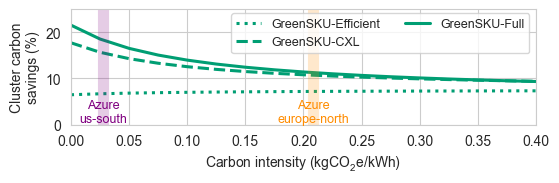

In [21]:
# Plot carbon savings relative to 0 for each config
grid_mix = 0.35
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(6, 1.5))
config_labels = [
    "GreenSKU-Efficient",
    "GreenSKU-CXL",
    "GreenSKU-Full",
]

blue = "#0072B2"
green = "#009E73"
orange = "#E69F00"
yellow = "#E69F00"
red = "#D55E00"
black = "#000000"
light_blue = "#56B4E9"
pink = "#CC79A7"
colors = [
    green,
    green,
    green
]

linestyles = [
    "dotted",
    "dashed",
    "solid",
]
azure_dcs = [
    'ussouth',
    'europenorth',
    # 'useast',
]
# google_dcs = [
#     'us-south1',
#     'us-east1'
# ]
azure_intensities = [get_dc_region_intensity(dc, azure_data) for dc in azure_dcs]
# google_intensities = [get_dc_region_intensity(dc, google_data) for dc in google_dcs]
intensities = azure_intensities 
# + google_intensities
intensity_colors = [
    "purple",
    "darkorange",
    # "blue",
    # "black",
]
annotations = [
    "Azure\nus-south",
    "Azure\neurope-north",
    # "Google\nus-south1",
    # "Google\nus-east1"
]

# Plot carbon savings for each config across carbon intensities
for i, config in enumerate(trace_config_data):
    ax.plot(CI_steps, 
            config["carbon_savings"], 
            label=config_labels[i], 
            color=colors[i], 
            linestyle=linestyles[i], 
            linewidth=2.2)

# Plot carbon intensity annotations
for i, intensity in enumerate(intensities):
    ax.axvline(x=intensity, color=intensity_colors[i], linestyle="-", alpha=0.2, linewidth=8)
    ax.annotate(annotations[i], xy=(intensity, 0.5), xycoords="data", ha="center", fontsize=9, color=intensity_colors[i], alpha=1)

# Set plot parameters
ax.set_xlim([0, 0.4])
ax.set_ylim([0, 25])
ax.set_ylim(bottom=0)
# ax.set_yticks(np.arange(0, 30, 10))
ax.set_xlabel("Carbon intensity (kgCO$\mathregular{_2}$e/kWh)", fontsize=10)
ax.set_ylabel("Cluster carbon\nsavings (%)", fontsize=10)

# Set legend above plot
ax.legend(loc="upper center", bbox_to_anchor=(0.665, 1.02), ncol=2, fontsize=9)

# Save plot to file
plt.savefig("../figures/generated_figures/Figure_12.png", bbox_inches="tight", dpi=500)